<a href="https://colab.research.google.com/github/geeorgebixleer/robot-trading-BTC-USD/blob/main/robot_trading_BTC_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Configurando el ambiente

In [1]:
# importando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time

In [2]:
# verificacion de versiones
!python -V
print('-----')
!pip show Pandas
print('-----')
!pip show Numpy
print('-----')
!pip show Matplotlib

Python 3.10.12
-----
Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, bigframes, bokeh, bqplot, cmdstanpy, cufflinks, datascience, db-dtypes, dopamine-rl, fastai, geemap, geopandas, google-colab, gspread-dataframe, holoviews, ibis-framework, lida, mizani, mlxtend, pandas-datareader, pandas-gbq, panel, plotnine, prophet, pymc, seaborn, sklearn-pandas, statsmodels, vega-datasets, xarray, yfinance
-----
Name: numpy
Version: 1.23.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: albumentations, 

In [3]:
# variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

#2. Obtención de Datos

##2.1. Histórico BTC-USD

In [4]:
def importar_base_bitcoin():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin = yf.Ticker("BTC-USD"). history(period='7d', interval='5m') # extracción precio ultimos 7 días
  df_bitcoin = pd.DataFrame(df_bitcoin) # transformando a dataframe
  return df_bitcoin
importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-11-07 00:00:00+00:00,35047.792969,35064.667969,35036.316406,35036.316406,0,0.0,0.0
2023-11-07 00:05:00+00:00,35020.574219,35031.777344,35006.933594,35006.933594,0,0.0,0.0
2023-11-07 00:10:00+00:00,34999.199219,35009.214844,34999.199219,35009.214844,0,0.0,0.0
2023-11-07 00:15:00+00:00,35010.875000,35038.589844,35010.875000,35038.589844,5142528,0.0,0.0
2023-11-07 00:20:00+00:00,35043.187500,35057.496094,35029.535156,35029.535156,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-13 18:35:00+00:00,36768.417969,36768.417969,36752.453125,36759.925781,12873728,0.0,0.0
2023-11-13 18:40:00+00:00,36762.332031,36778.082031,36762.332031,36778.082031,207872,0.0,0.0
2023-11-13 18:45:00+00:00,36778.390625,36793.921875,36778.199219,36778.199219,13899776,0.0,0.0


##2.2. Precio actual-tendencia BTC-USD

In [5]:
def extraer_tendencias():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'}
  url = 'https://coinmarketcap.com/'
  respuesta = requests.get(url, headers = headers) # conexión a página coinmarketcap
  s = BeautifulSoup(respuesta.content, features = 'lxml')
  respuesta = s.findAll('p', {'class':'sc-4984dd93-0 iqdbQL coin-item-symbol'}) # extraccion de criptomonedas

  indice = 0
  for item in respuesta: # ciclo que selecciona BTC entre las criptomonedas
    if item.getText()=='BTC':
     break
    indice+=1

  respuesta = s.findAll('div', {'class': ['sc-a0353bbc-0 gDrtaY', 'sc-0a353bbc-0 gDrtaY fall', 'sc-a0353bbc-0 gDrtaY rise' ]}) # extraccion de clases del precio
  precio_actual = float(respuesta[indice].getText().replace('$', '').replace(',','')) # conversión de precio a float y limpieza de caracteres

  lista = []
  respuesta = s.findAll('span', {'class': ['sc-d55c02b-0 iwhBxy', 'sc-55c02b-0 gUnzUB']}) # extracción de tendencias alta y baja
  for item in respuesta[::3]:
    lista.append(item)

  tendencia = '' # seleccion de tendencia baja o alta
  if lista[indice].find('span')['class'][0] == 'icon-Caret-down':
    tendencia = 'baja'
  else:
    tendencia = 'alta'
extraer_tendencias()

#3.Limpieza de Datos

In [6]:
def limpieza_datos():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin_limpio = pd.DataFrame(df_bitcoin) # dataframe para limpieza y tratamiento
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True) # eliminando valores nulos columna 'Close'
  volume0 = df_bitcoin_limpio['Volume'] > 0 # filtro valores >0
  df_bitcoin_limpio = df_bitcoin_limpio[volume0] #aplicando filtro en dataframe
limpieza_datos()

##3.4. Outliers ['Close']

<Axes: >

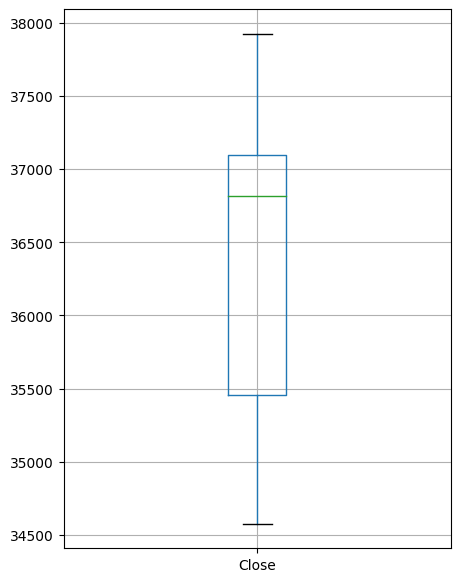

In [7]:
df_bitcoin.boxplot(['Close'], figsize = (5,7))

In [8]:
close = df_bitcoin_limpio['Close']
Q1 = close.quantile(.25) # quartil 1
Q3 = close.quantile(.75) # quartil 3
IIQ = Q3-Q1 # intervalo interquartil
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ
outliers_close = ((close >= limite_inferior) & (close <= limite_superior)) # filtro de seleccion de registros cuyo precio se encuentra entre Q1 y Q3
df_bitcoin_limpio = df_bitcoin_limpio[outliers_close] # aplicanfo filtro
media_bitcoin = df_bitcoin_limpio['Close'].mean() # obteniendo precio promedio

<Axes: >

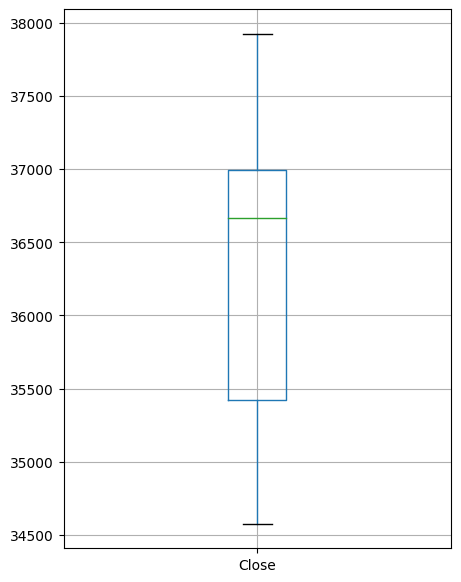

In [9]:
df_bitcoin_limpio.boxplot(['Close'], figsize = (5,7))

#4. Tomar Decisiones

In [10]:
def tomar_decisiones(): # algoritmo de toma de decisiones
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  if precio_actual >= media_bitcoin and tendencia == 'baja':
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
    algoritmo_decision = ' Comprar'
  else:
    algoritmo_decision = 'Espera'
  return algoritmo_decision
tomar_decisiones()

'Espera'

#5. Visualización

In [11]:
def visualizacion():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin['Promedio'] = media_bitcoin # nueva columna con precio promedio dataframe original
  fig = plt.figure(figsize=(16,5)) # generando tamaño de figura del gráfico
  eje = fig.add_axes([0,0,1,1]) # delimitando ejes de la figura
  eje.grid(True) # añadiendo cuadrícula

  eje.plot(df_bitcoin.index, df_bitcoin['Close'], color = 'g') # ejecutando gráfico con valores de fecha y precio de cierre
  eje.plot(df_bitcoin.index, df_bitcoin['Promedio'], color='r', linestyle='--') # ejecutando linea de precio promedio

  eje.set_title('Tendencia en tiempo real BTC-USD', fontsize=25, pad=20) # titulo
  eje.set_xlabel('Fecha', fontsize=20) # etiqueta eje x
  eje.set_ylabel('BTC-USD', fontsize=20) # etiqueta eje y

# impresión de texto con la decición de compra, venta o espera
  eje.annotate('{}'.format(algoritmo_decision), xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), fontsize=15, color='r')

# impresión de valores: precio actual, precio promedio y tendencia
  print('Precio actual BTC-USD: {} \nPrecio promedio BTC-USD: {} \nTendencia BTC-USD: {}'.format(precio_actual, media_bitcoin.round(3), tendencia))
  plt.show() # ejecución de gráfico

#6. Automatización

Precio actual BTC-USD: 36735.1 
Precio promedio BTC-USD: 36311.776 
Tendencia BTC-USD: alta


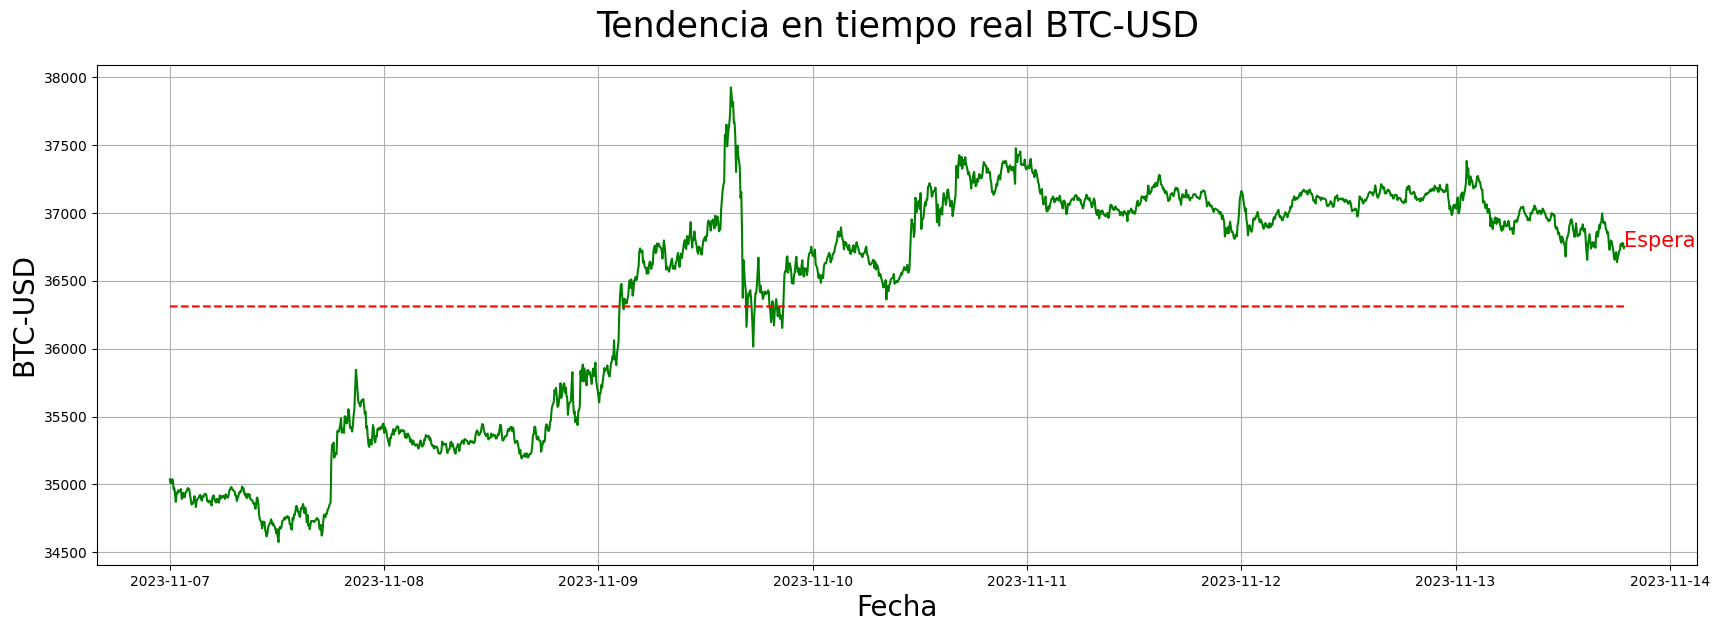

In [ ]:
while(True):
  clear_output() # limpia figura antes de plasmar gráfico
  importar_base_bitcoin() # extracción de datos BTC-USD
  extraer_tendencias() # extracción de precio y tendencia
  limpieza_datos() # limpieza de datos
  tomar_decisiones() # algoritmo de decsiones
  visualizacion() # gráfico de BTC-USD
  time.sleep(300) # actualiación de gráfico cada 5 minutos